In [1]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [2]:
import torch.optim as optim

dim=5
f_net = FNet(in_out_dim=dim, hidden_dim=128, n_hiddens=3, activation='leakyrelu')

import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'cite5_ho1',
    '--hold-one-out',
    '-ho', '1',
    '-e1', '2000',
    '-e2', '30',
    '-bs', '256',
    '-r', '0.01',
    '-rm', '5',
    '--norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'cite5_ho1', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': True, 'hold_out': 1, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 2000, 'norm_cost': True, 'reg': 0.01, 'reg_m': 5.0, 'n_big_batches': 1, 'n_batch': 256, 'learning_rate2': 0.0001, 'epochs2': 30}


device(type='cpu')

In [3]:
df = pd.read_csv(DATA_DIR + '/cite_pca50.csv')
df=df.iloc[:,:dim+1]
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


from sklearn.preprocessing import StandardScaler
import pandas as pd

cols_to_scale = [c for c in df.columns if c != "samples"]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
df = df_scaled


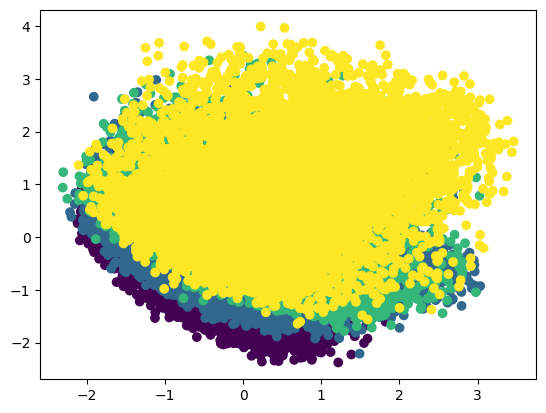

In [4]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [5]:
args.hold_out

1

In [6]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [7]:
f_net=f_net.to(device)

In [8]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

7476

In [9]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 0.9362, 1.2722, 0.9703], dtype=torch.float64)

In [10]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [11]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost,
    batch_size=args.n_batch
)


relative_mass tensor([1.0000, 0.9362, 1.2722, 0.9703], dtype=torch.float64)
t_train: [0, 2, 3]


Begin flow and growth matching...: 100%|██████████| 2000/2000 [04:18<00:00,  7.74epoch/s, loss=0.141267, vloss=0.140576, gloss=0.000690]


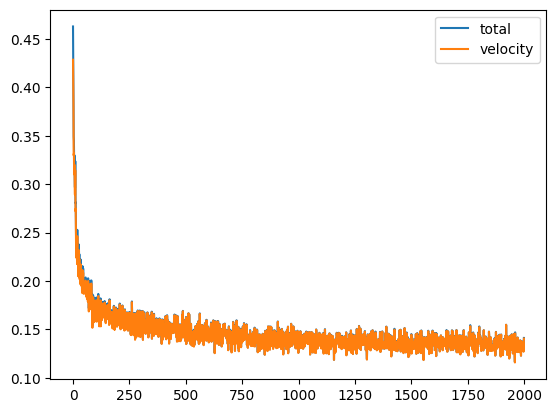

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
# plt.plot(g_losses,label='growth')
plt.legend()

In [13]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [14]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

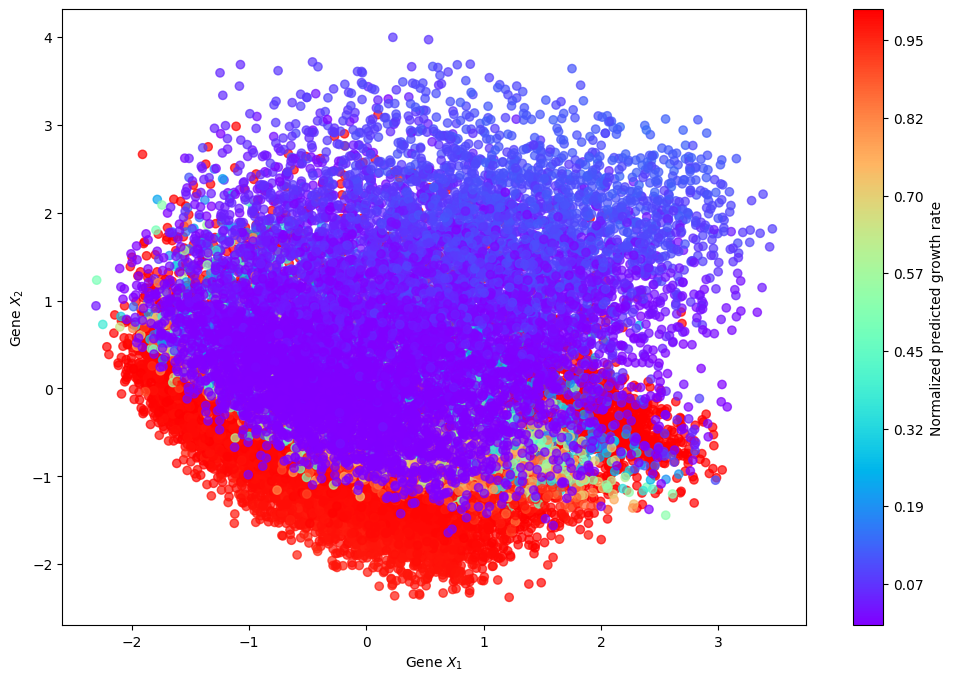

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 5

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [16]:
groups = [0,1,2,3]
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=False, hold_out=-1, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.1219886541366577,relative_mass_now:0.9361958266452648
RME:0.19845509048802024
Otloss:0.811494
total loss:0.811494
epoch_0_1:
relative_mass_pred:1.2587826251983643,relative_mass_now:1.2722043873729267
RME:0.010550004628012732
Otloss:0.444405
total loss:0.444405
epoch_0_2:
relative_mass_pred:0.9722631573677063,relative_mass_now:0.9703049759229535
RME:0.002018109247445807


d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:200: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
100%|██████████| 1/1 [00:34<00:00, 34.92s/it]

Otloss:0.791891
total loss:0.791891
New minimum otloss found: 0.7918911576271057. Model saved.


In [17]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0303, 0.0606, 0.0909, 0.1212, 0.1515, 0.1818, 0.2121, 0.2424,
        0.2727, 0.3030, 0.3333, 0.3636, 0.3939, 0.4242, 0.4545, 0.4848, 0.5152,
        0.5455, 0.5758, 0.6061, 0.6364, 0.6667, 0.6970, 0.7273, 0.7576, 0.7879,
        0.8182, 0.8485, 0.8788, 0.9091, 0.9394, 0.9697, 1.0000, 1.0303, 1.0606,
        1.0909, 1.1212, 1.1515, 1.1818, 1.2121, 1.2424, 1.2727, 1.3030, 1.3333,
        1.3636, 1.3939, 1.4242, 1.4545, 1.4848, 1.5152, 1.5455, 1.5758, 1.6061,
        1.6364, 1.6667, 1.6970, 1.7273, 1.7576, 1.7879, 1.8182, 1.8485, 1.8788,
        1.9091, 1.9394, 1.9697, 2.0000, 2.0303, 2.0606, 2.0909, 2.1212, 2.1515,
        2.1818, 2.2121, 2.2424, 2.2727, 2.3030, 2.3333, 2.3636, 2.3939, 2.4242,
        2.4545, 2.4848, 2.5152, 2.5455, 2.5758, 2.6061, 2.6364, 2.6667, 2.6970,
        2.7273, 2.7576, 2.7879, 2.8182, 2.8485, 2.8788, 2.9091, 2.9394, 2.9697,
        3.0000])
<class 'torch.Tensor'>


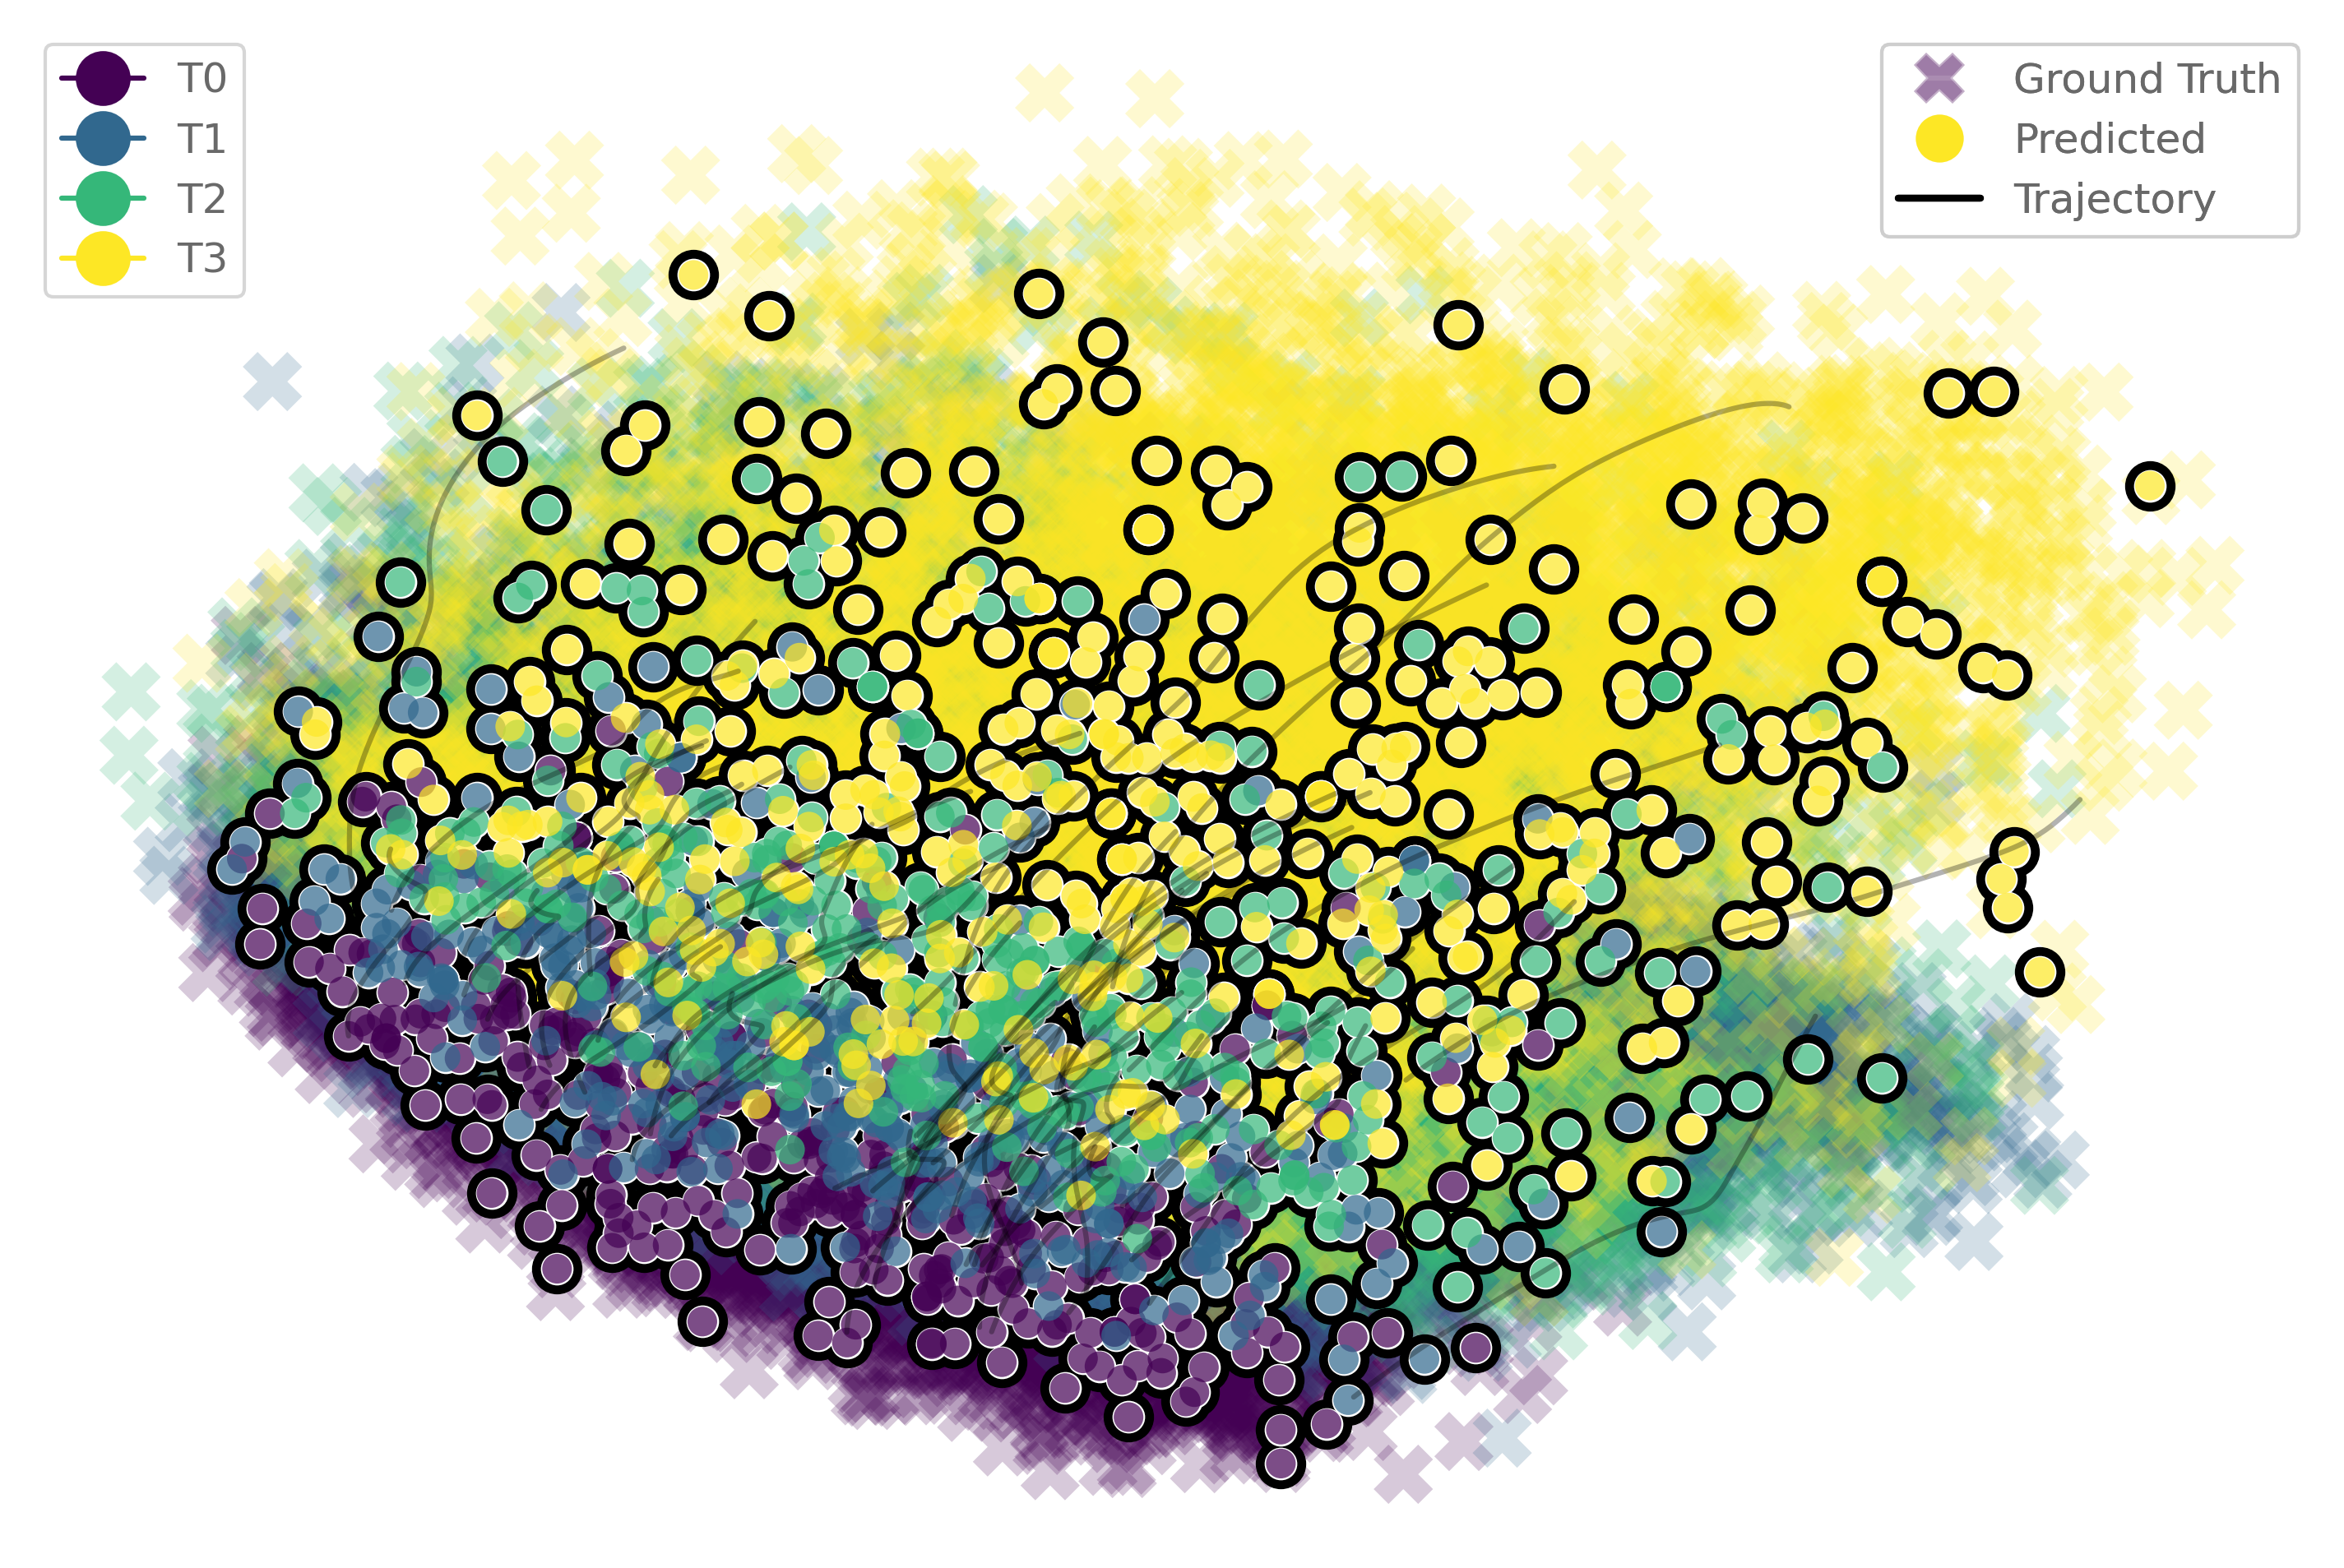

In [18]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

Note: below, `relative_mass_now` is also displayed at the hold-out time points, which may cause a mismatch with `relative_mass_pred`. Please manually align the predicted and ground-truth time points when comparing them.

In [19]:
logger.info("Incorporating $L_{ot}$")

# 训练阶段
l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)

# 累积损失
for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

[(0, 2), (2, 3)]
epoch_0_0:
relative_mass_pred:1.2581449747085571,relative_mass_now:0.9361958266452648
RME:0.34389081739122357
Otloss:0.433487
total loss:0.433487
epoch_0_1:
relative_mass_pred:0.9701767563819885,relative_mass_now:1.2722043873729267
RME:0.23740495944572115


  3%|▎         | 1/30 [00:23<11:34, 23.93s/it]

Otloss:0.716166
total loss:0.716166
New minimum otloss found: 0.7161658406257629. Model saved.
[(0, 2), (2, 3)]
epoch_1_0:
relative_mass_pred:1.2575924396514893,relative_mass_now:0.9361958266452648
RME:0.34330062563716734
Otloss:0.428945
total loss:0.428945
epoch_1_1:
relative_mass_pred:0.9690423011779785,relative_mass_now:1.2722043873729267
RME:0.2382966834605649


  7%|▋         | 2/30 [00:47<11:07, 23.85s/it]

Otloss:0.65165
total loss:0.65165
New minimum otloss found: 0.6516503095626831. Model saved.
[(0, 2), (2, 3)]
epoch_2_0:
relative_mass_pred:1.2571473121643066,relative_mass_now:0.9361958266452648
RME:0.3428251615574163
Otloss:0.425433
total loss:0.425433
epoch_2_1:
relative_mass_pred:0.9684024453163147,relative_mass_now:1.2722043873729267
RME:0.23879963398330686


 10%|█         | 3/30 [01:11<10:39, 23.69s/it]

Otloss:0.603183
total loss:0.603183
New minimum otloss found: 0.603183388710022. Model saved.
[(0, 2), (2, 3)]
epoch_3_0:
relative_mass_pred:1.2568745613098145,relative_mass_now:0.9361958266452648
RME:0.34253382202488547
Otloss:0.42198
total loss:0.42198
epoch_3_1:
relative_mass_pred:0.9682167768478394,relative_mass_now:1.2722043873729267
RME:0.2389455763101202


 13%|█▎        | 4/30 [01:34<10:07, 23.36s/it]

Otloss:0.573791
total loss:0.573791
New minimum otloss found: 0.5737910866737366. Model saved.
[(0, 2), (2, 3)]
epoch_4_0:
relative_mass_pred:1.2567769289016724,relative_mass_now:0.9361958266452648
RME:0.34242953571494544
Otloss:0.417994
total loss:0.417994
epoch_4_1:
relative_mass_pred:0.9683603048324585,relative_mass_now:1.2722043873729267
RME:0.23883275797208922


 17%|█▋        | 5/30 [01:56<09:33, 22.95s/it]

Otloss:0.557982
total loss:0.557982
New minimum otloss found: 0.5579817295074463. Model saved.
[(0, 2), (2, 3)]
epoch_5_0:
relative_mass_pred:1.256815791130066,relative_mass_now:0.9361958266452648
RME:0.3424710465049826
Otloss:0.413272
total loss:0.413272
epoch_5_1:
relative_mass_pred:0.9686965942382812,relative_mass_now:1.2722043873729267
RME:0.23856842198240033


 20%|██        | 6/30 [02:18<09:04, 22.69s/it]

Otloss:0.547614
total loss:0.547614
New minimum otloss found: 0.5476140379905701. Model saved.
[(0, 2), (2, 3)]
epoch_6_0:
relative_mass_pred:1.2569327354431152,relative_mass_now:0.9361958266452648
RME:0.34259596087622946
Otloss:0.408205
total loss:0.408205
epoch_6_1:
relative_mass_pred:0.9691036939620972,relative_mass_now:1.2722043873729267
RME:0.23824842644720448


 23%|██▎       | 7/30 [02:40<08:39, 22.59s/it]

Otloss:0.539312
total loss:0.539312
New minimum otloss found: 0.5393124222755432. Model saved.
[(0, 2), (2, 3)]
epoch_7_0:
relative_mass_pred:1.2570736408233643,relative_mass_now:0.9361958266452648
RME:0.3427464693235422
Otloss:0.403514
total loss:0.403514
epoch_7_1:
relative_mass_pred:0.9694929122924805,relative_mass_now:1.2722043873729267
RME:0.23794248635279322


 27%|██▋       | 8/30 [03:02<08:07, 22.18s/it]

Otloss:0.533538
total loss:0.533538
New minimum otloss found: 0.5335376858711243. Model saved.
[(0, 2), (2, 3)]
epoch_8_0:
relative_mass_pred:1.2571922540664673,relative_mass_now:0.9361958266452648
RME:0.3428731663667538
Otloss:0.3997
total loss:0.3997
epoch_8_1:
relative_mass_pred:0.9698005318641663,relative_mass_now:1.2722043873729267
RME:0.23770068591982896


 30%|███       | 9/30 [03:23<07:41, 21.98s/it]

Otloss:0.530849
total loss:0.530849
New minimum otloss found: 0.5308490991592407. Model saved.
[(0, 2), (2, 3)]
epoch_9_0:
relative_mass_pred:1.2572537660598755,relative_mass_now:0.9361958266452648
RME:0.3429388705620274
Otloss:0.396726
total loss:0.396726
epoch_9_1:
relative_mass_pred:0.969993531703949,relative_mass_now:1.2722043873729267
RME:0.23754898086229395


 33%|███▎      | 10/30 [03:44<07:14, 21.74s/it]

Otloss:0.529105
total loss:0.529105
New minimum otloss found: 0.5291046500205994. Model saved.
[(0, 2), (2, 3)]
epoch_10_0:
relative_mass_pred:1.2572438716888428,relative_mass_now:0.9361958266452648
RME:0.34292830186395046
Otloss:0.394205
total loss:0.394205
epoch_10_1:
relative_mass_pred:0.9700750112533569,relative_mass_now:1.2722043873729267
RME:0.2374849349037855


 37%|███▋      | 11/30 [04:06<06:54, 21.79s/it]

Otloss:0.525001
total loss:0.525001
New minimum otloss found: 0.5250011086463928. Model saved.
[(0, 2), (2, 3)]
epoch_11_0:
relative_mass_pred:1.2571759223937988,relative_mass_now:0.9361958266452648
RME:0.34285572164824124
Otloss:0.391889
total loss:0.391889
epoch_11_1:
relative_mass_pred:0.9700896739959717,relative_mass_now:1.2722043873729267
RME:0.23747340944234213


 40%|████      | 12/30 [04:28<06:29, 21.65s/it]

Otloss:0.517219
total loss:0.517219
New minimum otloss found: 0.5172193646430969. Model saved.
[(0, 2), (2, 3)]
epoch_12_0:
relative_mass_pred:1.2570807933807373,relative_mass_now:0.9361958266452648
RME:0.3427541093462484
Otloss:0.389709
total loss:0.389709
epoch_12_1:
relative_mass_pred:0.9700955152511597,relative_mass_now:1.2722043873729267
RME:0.23746881799835248


 43%|████▎     | 13/30 [04:49<06:04, 21.47s/it]

Otloss:0.507187
total loss:0.507187
New minimum otloss found: 0.507186770439148. Model saved.
[(0, 2), (2, 3)]
epoch_13_0:
relative_mass_pred:1.2569937705993652,relative_mass_now:0.9361958266452648
RME:0.34266115573665595
Otloss:0.387775
total loss:0.387775
epoch_13_1:
relative_mass_pred:0.9701399803161621,relative_mass_now:1.2722043873729267
RME:0.23743386680226813


 47%|████▋     | 14/30 [05:10<05:41, 21.37s/it]

Otloss:0.49757
total loss:0.49757
New minimum otloss found: 0.49756956100463867. Model saved.
[(0, 2), (2, 3)]
epoch_14_0:
relative_mass_pred:1.2569451332092285,relative_mass_now:0.9361958266452648
RME:0.3426092035822536
Otloss:0.386129
total loss:0.386129
epoch_14_1:
relative_mass_pred:0.9702408909797668,relative_mass_now:1.2722043873729267
RME:0.23735454726477376


 50%|█████     | 15/30 [05:31<05:17, 21.18s/it]

Otloss:0.490059
total loss:0.490059
New minimum otloss found: 0.4900592267513275. Model saved.
[(0, 2), (2, 3)]
epoch_15_0:
relative_mass_pred:1.2569482326507568,relative_mass_now:0.9361958266452648
RME:0.3426125142587596
Otloss:0.384657
total loss:0.384657
epoch_15_1:
relative_mass_pred:0.9703893661499023,relative_mass_now:1.2722043873729267
RME:0.2372378402547924


 53%|█████▎    | 16/30 [05:51<04:54, 21.02s/it]

Otloss:0.484378
total loss:0.484378
New minimum otloss found: 0.484378457069397. Model saved.
[(0, 2), (2, 3)]
epoch_16_0:
relative_mass_pred:1.2569948434829712,relative_mass_now:0.9361958266452648
RME:0.3426623017400619
Otloss:0.383213
total loss:0.383213
epoch_16_1:
relative_mass_pred:0.9705499410629272,relative_mass_now:1.2722043873729267
RME:0.23711162239654676


 57%|█████▋    | 17/30 [06:12<04:33, 21.00s/it]

Otloss:0.479713
total loss:0.479713
New minimum otloss found: 0.47971251606941223. Model saved.
[(0, 2), (2, 3)]
epoch_17_0:
relative_mass_pred:1.2570598125457764,relative_mass_now:0.9361958266452648
RME:0.3427316986129768
Otloss:0.38168
total loss:0.38168
epoch_17_1:
relative_mass_pred:0.9706763625144958,relative_mass_now:1.2722043873729267
RME:0.2370122504301997


 60%|██████    | 18/30 [06:33<04:12, 21.03s/it]

Otloss:0.475846
total loss:0.475846
New minimum otloss found: 0.47584599256515503. Model saved.
[(0, 2), (2, 3)]
epoch_18_0:
relative_mass_pred:1.257114291191101,relative_mass_now:0.9361958266452648
RME:0.3427898901192559
Otloss:0.379996
total loss:0.379996
epoch_18_1:
relative_mass_pred:0.9707306027412415,relative_mass_now:1.2722043873729267
RME:0.2369696155931531


 63%|██████▎   | 19/30 [06:54<03:51, 21.00s/it]

Otloss:0.472477
total loss:0.472477
New minimum otloss found: 0.4724771976470947. Model saved.
[(0, 2), (2, 3)]
epoch_19_0:
relative_mass_pred:1.2571392059326172,relative_mass_now:0.9361958266452648
RME:0.34281650286501597
Otloss:0.378206
total loss:0.378206
epoch_19_1:
relative_mass_pred:0.9707030057907104,relative_mass_now:1.2722043873729267
RME:0.23699130782343064


 67%|██████▋   | 20/30 [07:15<03:29, 20.90s/it]

Otloss:0.469107
total loss:0.469107
New minimum otloss found: 0.469107449054718. Model saved.
[(0, 2), (2, 3)]
epoch_20_0:
relative_mass_pred:1.257134199142456,relative_mass_now:0.9361958266452648
RME:0.3428111548491216
Otloss:0.376452
total loss:0.376452
epoch_20_1:
relative_mass_pred:0.9706190824508667,relative_mass_now:1.2722043873729267
RME:0.23705727469217966


 70%|███████   | 21/30 [07:36<03:08, 20.90s/it]

Otloss:0.465454
total loss:0.465454
New minimum otloss found: 0.4654536247253418. Model saved.
[(0, 2), (2, 3)]
epoch_21_0:
relative_mass_pred:1.2571148872375488,relative_mass_now:0.9361958266452648
RME:0.34279052678781474
Otloss:0.374837
total loss:0.374837
epoch_21_1:
relative_mass_pred:0.9705265760421753,relative_mass_now:1.2722043873729267
RME:0.23712998817250527


 73%|███████▎  | 22/30 [07:57<02:46, 20.85s/it]

Otloss:0.461567
total loss:0.461567
New minimum otloss found: 0.46156740188598633. Model saved.
[(0, 2), (2, 3)]
epoch_22_0:
relative_mass_pred:1.2571024894714355,relative_mass_now:0.9361958266452648
RME:0.34277728408179065
Otloss:0.373302
total loss:0.373302
epoch_22_1:
relative_mass_pred:0.9704701900482178,relative_mass_now:1.2722043873729267
RME:0.23717430966244601


 77%|███████▋  | 23/30 [08:17<02:24, 20.69s/it]

Otloss:0.457644
total loss:0.457644
New minimum otloss found: 0.4576440155506134. Model saved.
[(0, 2), (2, 3)]
epoch_23_0:
relative_mass_pred:1.2571094036102295,relative_mass_now:0.9361958266452648
RME:0.3427846694370733
Otloss:0.371763
total loss:0.371763
epoch_23_1:
relative_mass_pred:0.9704691171646118,relative_mass_now:1.2722043873729267
RME:0.2371751529888931


 80%|████████  | 24/30 [08:37<02:03, 20.56s/it]

Otloss:0.453963
total loss:0.453963
New minimum otloss found: 0.45396265387535095. Model saved.
[(0, 2), (2, 3)]
epoch_24_0:
relative_mass_pred:1.2571332454681396,relative_mass_now:0.9361958266452648
RME:0.3428101361794274
Otloss:0.37027
total loss:0.37027
epoch_24_1:
relative_mass_pred:0.9705069661140442,relative_mass_now:1.2722043873729267
RME:0.23714540230589906


 83%|████████▎ | 25/30 [08:58<01:42, 20.53s/it]

Otloss:0.45091
total loss:0.45091
New minimum otloss found: 0.45091021060943604. Model saved.
[(0, 2), (2, 3)]
epoch_25_0:
relative_mass_pred:1.2571582794189453,relative_mass_now:0.9361958266452648
RME:0.34283687625889925
Otloss:0.368909
total loss:0.368909
epoch_25_1:
relative_mass_pred:0.9705458283424377,relative_mass_now:1.2722043873729267
RME:0.2371148551479272


 87%|████████▋ | 26/30 [09:18<01:21, 20.38s/it]

Otloss:0.448532
total loss:0.448532
New minimum otloss found: 0.4485320448875427. Model saved.
[(0, 2), (2, 3)]
epoch_26_0:
relative_mass_pred:1.257167935371399,relative_mass_now:0.9361958266452648
RME:0.34284719028955263
Otloss:0.367659
total loss:0.367659
epoch_26_1:
relative_mass_pred:0.9705488681793213,relative_mass_now:1.2722043873729267
RME:0.23711246572299383


 90%|█████████ | 27/30 [09:38<01:01, 20.35s/it]

Otloss:0.44638
total loss:0.44638
New minimum otloss found: 0.44638025760650635. Model saved.
[(0, 2), (2, 3)]
epoch_27_0:
relative_mass_pred:1.2571545839309692,relative_mass_now:0.9361958266452648
RME:0.3428329289138343
Otloss:0.366431
total loss:0.366431
epoch_27_1:
relative_mass_pred:0.9705019593238831,relative_mass_now:1.2722043873729267
RME:0.23714933782931874


 93%|█████████▎| 28/30 [09:58<00:40, 20.35s/it]

Otloss:0.444063
total loss:0.444063
New minimum otloss found: 0.44406333565711975. Model saved.
[(0, 2), (2, 3)]
epoch_28_0:
relative_mass_pred:1.257124423980713,relative_mass_now:0.9361958266452648
RME:0.3428007134847564
Otloss:0.365224
total loss:0.365224
epoch_28_1:
relative_mass_pred:0.9704217910766602,relative_mass_now:1.2722043873729267
RME:0.23721235305550298


 97%|█████████▋| 29/30 [10:18<00:20, 20.30s/it]

Otloss:0.441724
total loss:0.441724
New minimum otloss found: 0.44172388315200806. Model saved.
[(0, 2), (2, 3)]
epoch_29_0:
relative_mass_pred:1.257093906402588,relative_mass_now:0.9361958266452648
RME:0.34276811605454316
Otloss:0.364095
total loss:0.364095
epoch_29_1:
relative_mass_pred:0.9703450202941895,relative_mass_now:1.2722043873729267
RME:0.23727269774793816


100%|██████████| 30/30 [10:38<00:00, 21.30s/it]

Otloss:0.439628
total loss:0.439628
New minimum otloss found: 0.43962764739990234. Model saved.


In [ ]:
plt.plot(l_loss[f'0:2'],label = 't1')
plt.plot(l_loss[f'2:3'],label = 't2')
plt.legend()

### Test

In [20]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [21]:
groups =[0,1,2,3] #including the hold-out time point

For simplicity, we present the prediction results using function `train` by setting `epoch=1`, `hold_one_out=False` and `hold_out=-1`, one just need to focus on the **hold-out** time points.  
For example, if the hold-out time point is **n**, then the **OT loss of `epoch0_{n-1}`** corresponds to the **EMD at the hold-out time point**.


In [22]:
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=False, hold_out=-1, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:1.1221133470535278,relative_mass_now:0.9361958266452648
RME:0.19858828155053215
Otloss:0.788288
total loss:0.788288
epoch_0_1:
relative_mass_pred:1.2570494413375854,relative_mass_now:1.2722043873729267
RME:0.011912351651793867
Otloss:0.362887
total loss:0.362887
epoch_0_2:
relative_mass_pred:0.9702284336090088,relative_mass_now:0.9703049759229535
RME:7.888479997941816e-05


100%|██████████| 1/1 [00:30<00:00, 30.17s/it]

Otloss:0.437104
total loss:0.437104
New minimum otloss found: 0.4371037781238556. Model saved.


In [23]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=100, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0303, 0.0606, 0.0909, 0.1212, 0.1515, 0.1818, 0.2121, 0.2424,
        0.2727, 0.3030, 0.3333, 0.3636, 0.3939, 0.4242, 0.4545, 0.4848, 0.5152,
        0.5455, 0.5758, 0.6061, 0.6364, 0.6667, 0.6970, 0.7273, 0.7576, 0.7879,
        0.8182, 0.8485, 0.8788, 0.9091, 0.9394, 0.9697, 1.0000, 1.0303, 1.0606,
        1.0909, 1.1212, 1.1515, 1.1818, 1.2121, 1.2424, 1.2727, 1.3030, 1.3333,
        1.3636, 1.3939, 1.4242, 1.4545, 1.4848, 1.5152, 1.5455, 1.5758, 1.6061,
        1.6364, 1.6667, 1.6970, 1.7273, 1.7576, 1.7879, 1.8182, 1.8485, 1.8788,
        1.9091, 1.9394, 1.9697, 2.0000, 2.0303, 2.0606, 2.0909, 2.1212, 2.1515,
        2.1818, 2.2121, 2.2424, 2.2727, 2.3030, 2.3333, 2.3636, 2.3939, 2.4242,
        2.4545, 2.4848, 2.5152, 2.5455, 2.5758, 2.6061, 2.6364, 2.6667, 2.6970,
        2.7273, 2.7576, 2.7879, 2.8182, 2.8485, 2.8788, 2.9091, 2.9394, 2.9697,
        3.0000])
<class 'torch.Tensor'>


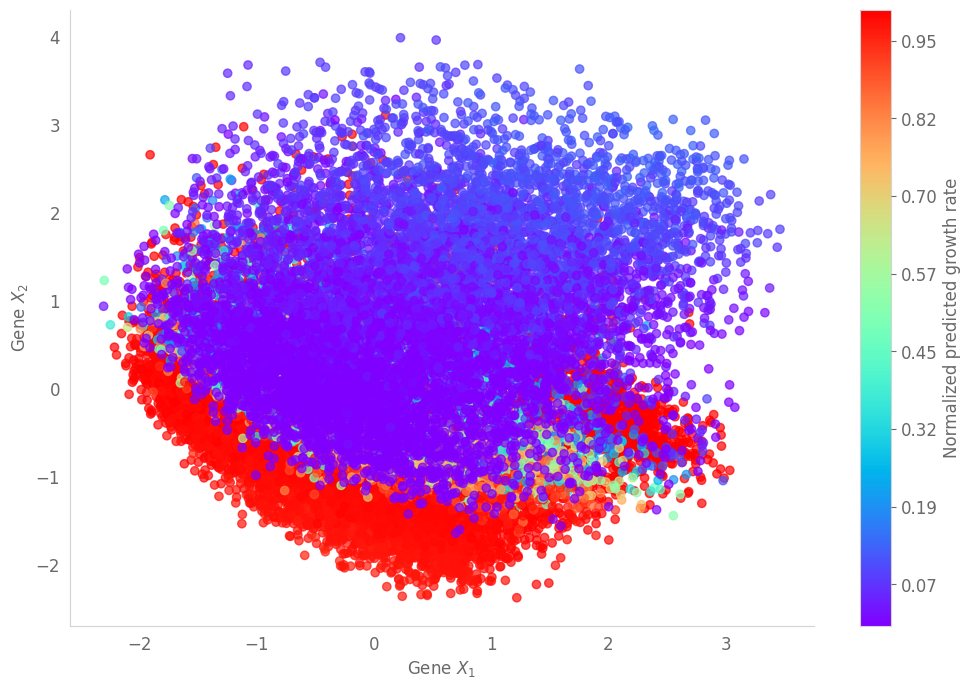

In [24]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 5

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

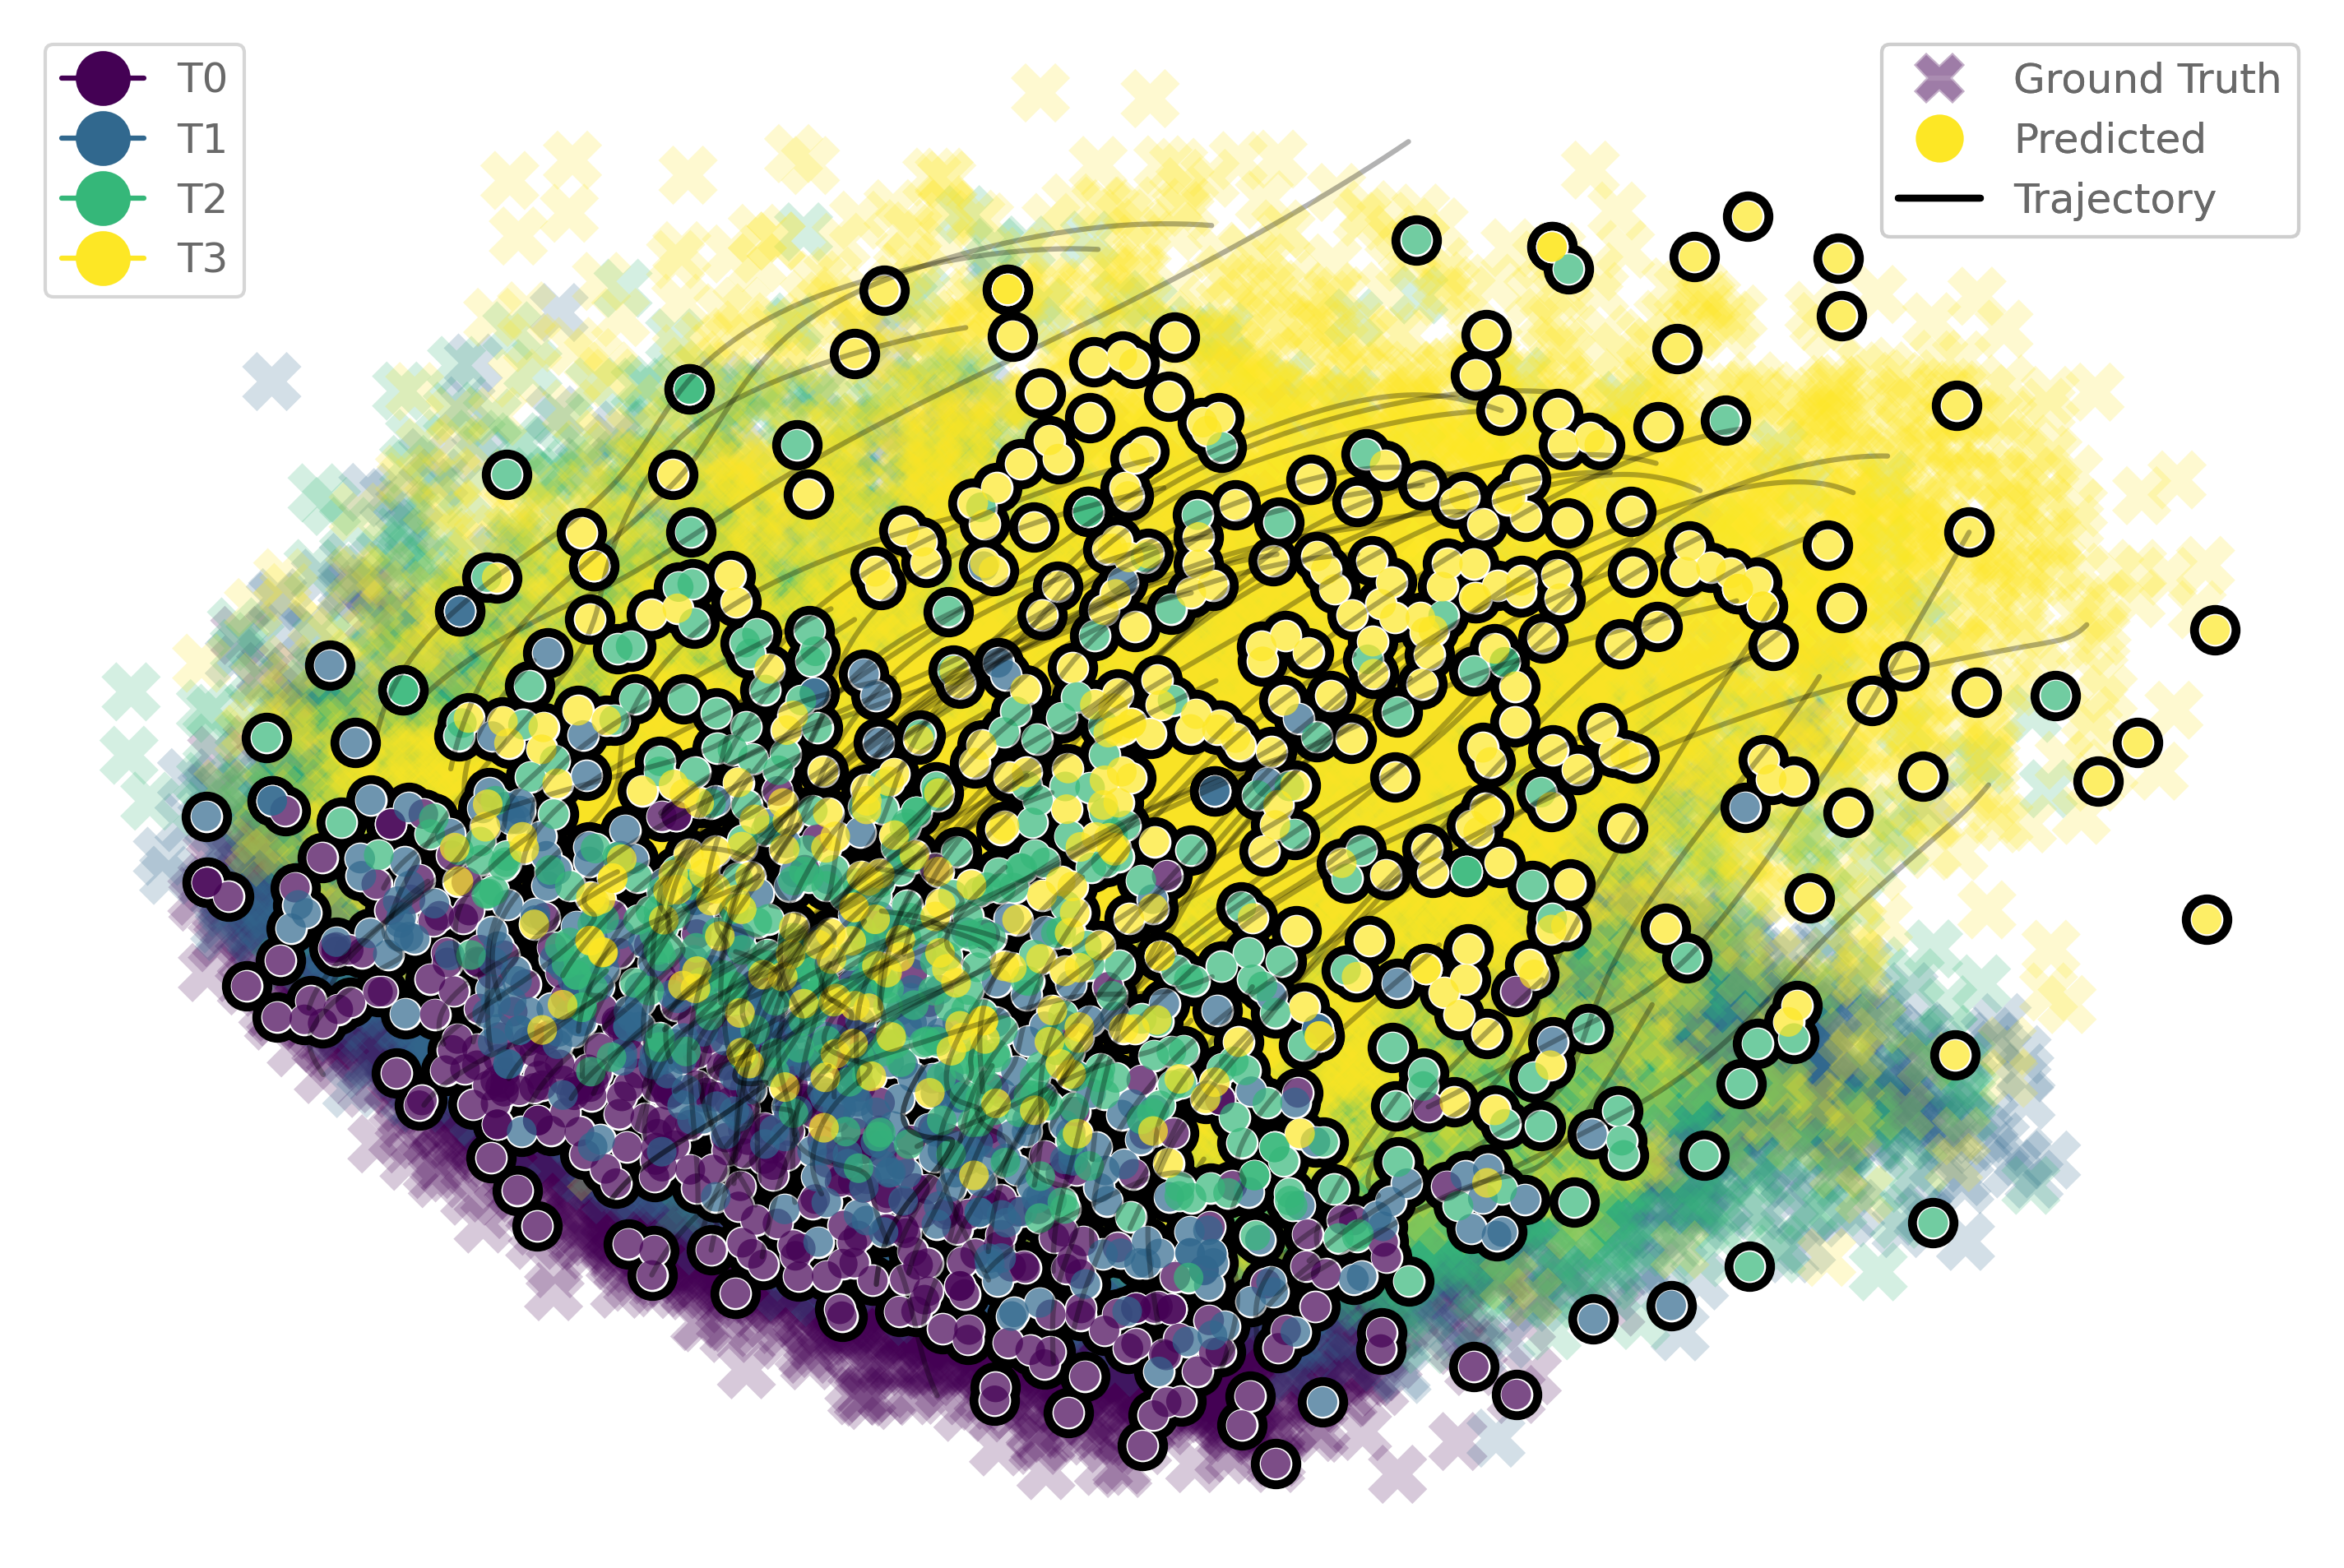

In [25]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)